# Preprocess weather data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/AnujTiwari/India-State-and-Country-Shapefile-Updated-Jan-2020.git

Cloning into 'India-State-and-Country-Shapefile-Updated-Jan-2020'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (28/28), 16.46 MiB | 9.78 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
!pip install metpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 28.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import shapely
import metpy.calc
import metpy.units
from google.colab import auth
from google.cloud import bigquery
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
pd.options.mode.chained_assignment = None

In [ ]:
reference_day = pd.Timestamp("2018-01-01")


def standardize_date(timestamps):
    if timestamps.tz:
        ref = reference_day.tz_localize(timestamps.tz)
    else:
        ref = reference_day
    return (timestamps-ref).days

def standardize_date_series(timestamps):
    if timestamps.dt.tz:
        ref = reference_day.tz_localize(timestamps.dt.tz)
    else:
        ref = reference_day
    return (timestamps-ref).dt.days

def destandardize_date(date):
    return reference_day + pd.Timedelta(days=date)

## Weather/Soil data

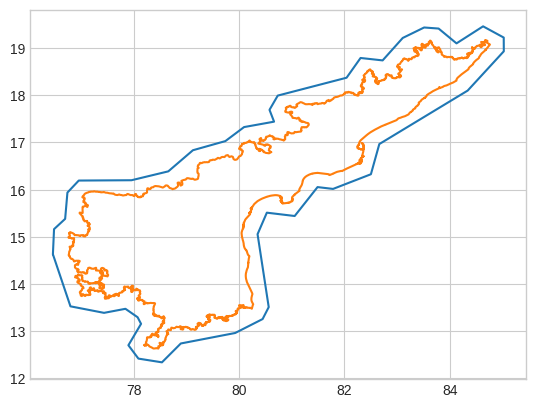

In [ ]:
crs = 4326
scale = 11132

states = gpd.read_file("India-State-and-Country-Shapefile-Updated-Jan-2020/India_State_Boundary.shp")
states.to_crs(epsg=crs, inplace=True)

ap_geometry_orig = states.loc[states["State_Name"]
                         == "Andhra Pradesh"].geometry.iat[0]

ap_geometry = ap_geometry_orig.buffer(0.3).simplify(0.1)

fig, ax = plt.subplots(1)
ax.plot(ap_geometry.exterior.xy[0], ap_geometry.exterior.xy[1])
ax.plot(ap_geometry_orig.exterior.xy[0], ap_geometry_orig.exterior.xy[1])

In [ ]:
dates = pd.date_range(start='2017-11-26', end='2024-01-10')

In [ ]:
total_df = pd.read_feather("/content/drive/MyDrive/data/ap/total.feather")

In [ ]:
total_df

,index,cell_id,dewpoint_temperature_2m,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,surface_pressure,surface_solar_radiation_downwards_sum,temperature_2m,total_evaporation_sum,total_precipitation_sum,u_component_of_wind_10m,v_component_of_wind_10m,date
0,0,"781,123",291.546509,0.436157,1.445440,95245.953125,10605896.0,296.526245,-0.001992,0.000267,-1.781071,-1.439973,-36
1,1,"782,123",291.658234,0.135864,1.405156,95219.703125,10278708.0,296.502380,-0.001954,0.000340,-1.736719,-1.448823,-36
2,2,"783,123",292.147247,0.000000,1.419683,96114.656250,9940436.0,296.806763,-0.001808,0.000424,-1.689477,-1.438610,-36
3,3,"784,123",292.542603,0.000000,1.557454,96597.406250,9599068.0,296.846802,-0.001849,0.000614,-1.609277,-1.415478,-36
4,4,"785,123",292.443390,4.068115,2.084829,95490.281250,9252156.0,296.122345,-0.002107,0.001017,-1.463322,-1.367667,-36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348662,2386,"837,194",289.129974,3.795888,2.365606,97671.906250,14555920.0,296.718811,-0.001514,0.000002,-0.142098,-0.189070,2200
5348663,2387,"838,194",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200
5348664,2388,"845,194",291.037445,2.041061,2.243357,100255.695312,16355652.0,295.858612,-0.001757,0.000002,-0.212329,0.558692,2200
5348665,2389,"846,194",291.629730,2.224131,2.068019,101034.531250,16399320.0,296.103088,-0.001735,0.000002,-0.283496,0.731666,2200


In [ ]:
grid = gpd.read_file("/content/drive/MyDrive/data/ap/grid.geojson")

In [ ]:
total_df["wind_speed"] = np.sqrt(np.square(total_df["u_component_of_wind_10m"]) + np.square(total_df["v_component_of_wind_10m"]))
total_df["relative_humidity"] = metpy.calc.relative_humidity_from_dewpoint(
    total_df["temperature_2m"].to_numpy() * metpy.units.units.kelvin,
    total_df["dewpoint_temperature_2m"].to_numpy() * metpy.units.units.kelvin,
).magnitude

total_df = total_df.rename({
    "temperature_2m": "temperature",
    "total_precipitation_sum": "precipitation",
    "surface_solar_radiation_downwards_sum": "solar_radiation",
}, axis=1)
total_df.drop(columns=["u_component_of_wind_10m", "v_component_of_wind_10m", "dewpoint_temperature_2m"], inplace=True)


In [ ]:
total_df.isna().sum() / len(total_df)

index                              0.000000
cell_id                            0.000000
leaf_area_index_high_vegetation    0.145546
leaf_area_index_low_vegetation     0.145546
surface_pressure                   0.145546
solar_radiation                    0.132589
temperature                        0.145546
total_evaporation_sum              0.145546
precipitation                      0.145546
date                               0.000000
wind_speed                         0.145546
relative_humidity                  0.145546
dtype: float64

In [ ]:
covariates = sorted(list(set(total_df.columns) - set(("cell_id", "geometry", "date", "index"))))

In [ ]:
total_df_lag = total_df.copy()

In [ ]:
total_df.sort_values(by=['date', 'cell_id'], inplace=True)
grouped = total_df.groupby('cell_id')

for covariate in covariates:
    for lag_i in range(1, 30):
        total_df_lag[f"{covariate}_l{lag_i}"] = grouped[covariate].shift(lag_i)

In [ ]:
# test lags
for _ in range(10):
    cell_id = np.random.choice(total_df.cell_id)
    date = np.random.choice(2100)
    lag_i = np.random.choice(29)
    covariate = np.random.choice(covariates)
    orig = total_df_lag.loc[(total_df_lag.cell_id == cell_id) & (total_df_lag.date == date), f"{covariate}"].iloc[0]
    lagged = total_df_lag.loc[(total_df_lag.cell_id == cell_id) & (total_df_lag.date == date+lag_i), f"{covariate}_l{lag_i}"].iloc[0]
    if np.isnan(orig) and np.isnan(lagged):
        continue
    assert np.isclose(orig, lagged)

In [ ]:
total_df_lag

,index,cell_id,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,surface_pressure,solar_radiation,temperature,total_evaporation_sum,precipitation,date,...,wind_speed_l20,wind_speed_l21,wind_speed_l22,wind_speed_l23,wind_speed_l24,wind_speed_l25,wind_speed_l26,wind_speed_l27,wind_speed_l28,wind_speed_l29
0,0,"781,123",0.436157,1.445440,95245.953125,10605896.0,296.526245,-0.001992,0.000267,-36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"782,123",0.135864,1.405156,95219.703125,10278708.0,296.502380,-0.001954,0.000340,-36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"783,123",0.000000,1.419683,96114.656250,9940436.0,296.806763,-0.001808,0.000424,-36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"784,123",0.000000,1.557454,96597.406250,9599068.0,296.846802,-0.001849,0.000614,-36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"785,123",4.068115,2.084829,95490.281250,9252156.0,296.122345,-0.002107,0.001017,-36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348662,2386,"837,194",3.795888,2.365606,97671.906250,14555920.0,296.718811,-0.001514,0.000002,2200,...,0.699615,1.118871,1.272630,1.023858,0.891740,1.041974,0.769346,0.856535,0.878885,0.539696
5348663,2387,"838,194",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5348664,2388,"845,194",2.041061,2.243357,100255.695312,16355652.0,295.858612,-0.001757,0.000002,2200,...,0.279345,0.498647,0.562910,0.422197,0.190141,0.191832,0.440948,0.370164,0.390498,0.246463
5348665,2389,"846,194",2.224131,2.068019,101034.531250,16399320.0,296.103088,-0.001735,0.000002,2200,...,0.216956,0.553053,0.668663,0.511033,0.248567,0.171957,0.503147,0.322913,0.345988,0.182223


In [ ]:
total_df_lag.to_feather("/content/drive/MyDrive/data/ap/total_processed.feather")